# Assignment 4: Language Processing with RNN-Based Autoencoders

**Deadline**: Sunday, June 15th, by 9pm.


**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

In this assignement, we will practice the application of deep learning to natural language processing.
We will be working with a subset of Reuters news headlines that are collected over 15 months,
covering all of 2019, plus a few months in 2018 and in a few months of this year.

In particular, we will be building an **autoencoder** of news headlines. The idea is similar
to the kind of image autoencoder we built in lecture: we will have an **encoder** that
maps a news headline to a vector embedding, and then a **decoder** that reconstructs
the news headline. Both our encoder and decoder networks will be Recurrent Neural Networks,
so that you have a chance to practice building

- a neural network that takes a sequence as an input
- a neural network that generates a sequence as an output

This assignment is organized as follows:

- Question 1. Exploring the data
- Question 2. Building the autoencoder
- Question 3. Training the autoencoder using *data augmentation*
- Question 4. Analyzing the embeddings (interpolating between headlines)

Furthermore, we'll be introducing the idea of **data augmentation** for improving of
the robustness of the autoencoder, as proposed by Shen et al [1] in ICML 2020.

[1] Shen, Tianxiao, Jonas Mueller, Regina Barzilay, and Tommi Jaakkola. "Educating text autoencoders: Latent representation guidance via denoising." In International Conference on Machine Learning, pp. 8719-8729. PMLR, 2020.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Question 1. Data (20 %)

Download the files `reuters_train.txt` and `reuters_valid.txt`, and upload them to Google Drive.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/Shareddrives/DNN_Elad_Raviv/ASS/ass4/reuters_train.txt' # Update me
valid_path = '/content/gdrive/Shareddrives/DNN_Elad_Raviv/ASS/ass4/reuters_valid.txt' # Update me

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


As we did in some of our examples (e.g., training transformers on IMDB reviews) will be using PyTorch's `torchtext` utilities to help us load, process,
and batch the data. We'll be using a `TabularDataset` to load our data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). Our tabular dataset
is even simpler: we have no labels, just some text. So, we are treating our data as a table with one field
representing our sequence.

In [ ]:
import torchtext.legacy.data as data

# Tokenization function to separate a headline into words
def tokenize_headline(headline):
    """Returns the sequence of words in the string headline. We also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the headline.
    """
    return ("<bos> " + headline + " <eos>").split()

# Data field (column) representing our *text*.
text_field = data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_headline, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True used in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index
train_data = data.TabularDataset(
    path=train_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

### Part (a) -- 5%

Draw histograms of the number of words per headline in our training set.
Excluding the `<bos>` and `<eos>` tags in your computation.
Explain why we would be interested in such histograms.

(array([1.1200e+02, 2.9700e+02, 2.9310e+03, 6.1630e+03, 1.2529e+04,
        4.8726e+04, 2.9969e+04, 2.6251e+04, 3.1818e+04, 6.8520e+03,
        3.3640e+03, 2.0980e+03, 2.2700e+02, 7.7000e+01, 2.0000e+01,
        3.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 2.  ,  3.35,  4.7 ,  6.05,  7.4 ,  8.75, 10.1 , 11.45, 12.8 ,
        14.15, 15.5 , 16.85, 18.2 , 19.55, 20.9 , 22.25, 23.6 , 24.95,
        26.3 , 27.65, 29.  ]),
 <a list of 20 Patch objects>)

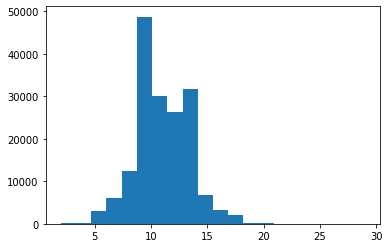

In [ ]:

title_quntities = [len(data_sample.title) - 2 for data_sample in train_data]

plt.hist(title_quntities, bins=20)



**Write your explanation here:**
This histogram may grasp our curiosity for a variety of reasons.
1) understanding the headline length distribution may aid us in determining the expected range of headline lengths that the decoder must create. It allows us to see if the produced headline length is fair (and if it isn't, we can disregard it), and therefore determine whether the model is working well. 

2) while training the model, it may be preferable to avoid or treat headlines with short lengths or really long lengths more cautiously since it's deviate from the headlines' distribution.

3) (O) notation - run-time prespective
Another reason we can think of is that knowing the distribution of the title's lengths can help us get an indication to the run time of the autoencoder's training, as well as to the decoder's sequence generation procces. 


### Part (b) -- 5%

How many distinct words appear in the training data?
Exclude the `<bos>` and `<eos>` tags in your computation.

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# You might find the python class Counter from the collections package useful
words = {}
for sample in train_data:
  for word in sample.title[1:-1]:
    words[word] = words.get(word, 0) + 1

print("There are", len(words.keys()),"distinct words (excluding the '<bos>' and '<eos>')")

There are 51298 distinct words (excluding the '<bos>' and '<eos>')


### Part (c) -- 5%

The distribution of *words* will have a long tail, meaning that there are some words
that will appear very often, and many words that will appear infrequently. How many words
appear exactly once in the training set? Exactly twice?
Print these numbers below

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values
print("words which appear twice: "+ str(len(list(filter(lambda x: x[1]==1, words.items())))))
print("words which appear twice: "+ str(len(list(filter(lambda x: x[1]==2, words.items())))))


words which appear twice: 19854
words which appear twice: 7193


### Part (d) -- 5%
We will replace the infrequent
words with an `<unk>` tag, instead of learning embeddings for these rare words. `torchtext` also provides us with the `<pad>` tag used for padding short sequences for batching.
We will thus only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, `<unk>`, and `<pad>`.

What percentage of total word count(whole dataset) will be supported? Alternatively, what percentage
of total word count(whole dataset) in the training set will be set to the `<unk>` tag?

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values
from collections import Counter, OrderedDict

words = [w for sample in train_data for w in sample.title]
word_count = Counter(words)

del word_count["<bos>"]
del word_count["<eos>"]
total_words = sum(word_count.values())

ordered_dict = OrderedDict(sorted(word_count.items(), key=lambda x: x[1],reverse=True))
supported_words_count = sum(list(ordered_dict.values())[:9995])
print(supported_words_count/total_words*100, "% of the dataset is supported")




93.97857393100142 % of the dataset is supported


The `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.

In [ ]:
# Build the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful for us
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, we can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of our vocabulary  
vocab_size = len(text_field.vocab.stoi) 

# Here are the two tokens that torchtext adds for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in our vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching   


0
on
<unk>
<pad>


## Question 2. Text Autoencoder (40%)

Building a text autoencoder is a little more complicated than an image autoencoder like we did in class. So
we will need to thoroughly understand the model that we want to build before actually building it. Note that the best and fastest way to complete this assignment is to spend time upfront understanding the architecture. The explanations are quite dense, but it is important to understand the operation of this model. The rationale here is similar in nature to the `seq2seq` RNN model we discussed in class, only we are dealing with unsupervised learning here rather than machine translation. 

# Architecture description
Here is a diagram showing our desired architecture:

<img src='https://drive.google.com/uc?id=1UaXAYQvmFbBcuSBQb7ozjSliuVn7bP1Q'>

There are two main components to the model: the **encoder** and the **decoder**.
As always with neural networks, we'll first describe how to make
**predictions** with of these components. Let's get started:

The **encoder** will take a sequence of words (a headline) as *input*, and produce an
embedding (a vector) that represents the entire headline. In the diagram above,
the vector ${\bf h}^{(7)}$ is the vector embedding containing information about 
the entire headline.  This portion is very similar
to the sentiment analysis RNN that we discussed in lecture (but without the fully-connected
layer that makes a prediction).

The **decoder** will take an embedding (in the diagram, the vector ${\bf h}^{(7)}$) as input,
and uses a separate RNN to **generate a sequence of words**. To generate a sequence of words,
the decoder needs to do the following:


1.   Determine the previous word that was generated. This previous word will act as ${\bf x}^{(t)}$
   to our RNN, and will be used to update the hidden state ${\bf m}^{(t)}$. Since each of our
   sequences begin with the `<bos>` token, we'll set ${\bf x}^{(1)}$ to be the `<bos>` token.
2.   Compute the updates to the hidden state ${\bf m}^{(t)}$ based on the previous hidden state
   ${\bf m}^{(t-1)}$ and ${\bf x}^{(t)}$. Intuitively, this hidden state vector ${\bf m}^{(t)}$
   is a representation of *all the words we still need to generate*.
3. We'll use a fully-connected layer to take a hidden state ${\bf m}^{(t)}$, and determine
   *what the next word should be*. This fully-connected layer solves a *classification problem*,
   since we are trying to choose a word out of $K=$ `vocab_size` distinct words. As in a classification
   problem, the fully-connected neural network will compute a *probability distribution* over
   these `vocab_size` words. In the diagram, we are using ${\bf z}^{(t)}$ to represent the logits,
   or the pre-softmax activation values representing the probability distribution.
4. We will need to *sample* an actual word from this probability distribution ${\bf z}^{(t)}$.
   We can do this in a number of ways, which we'll discuss in question 3. For now, you can 
   imagine your favourite way of picking a word given a distribution over words.
5. This word we choose will become the next input ${\bf x}^{(t+1)}$ to our RNN, which is used
   to update our hidden state ${\bf m}^{(t+1)}$, i.e., to determine what are the remaining
   words to be generated.

We can repeat this process until we see an `<eos>` token generated, or until the generated
sequence becomes too long.

# Training the architecture
While our autoencoder produces a sequence, computing the loss by comparing the complete generated sequence to the ground truth (the encoder input) gives rise to multiple challanges. One is that the generated
sequence might be longer or shorter than the actual sequence, meaning that there may
be more/fewer ${\bf z}^{(t)}$s than ground-truth words. Another more insidious issue
is that the **gradients will become very high-variance and unstable**, because
**early mistakes will easily throw the model off-track**. Early in training,
our model is unlikely to produce the right answer in step $t=1$, so the gradients
we obtain based on the other time steps will not be very useful.

At this point, you might have some ideas about "hacks" we can use to make training
work. Fortunately, there is one very well-established solution called
**teacher forcing** which we can use for training:
instead of *sampling* the next word based on ${\bf z}^{(t)}$, we will forget sampling,
and use the **ground truth** ${\bf x}^{(t)}$ as the input in the next step.

Here is a diagram showing how we can use **teacher forcing** to train our model:
 
<img src='https://drive.google.com/uc?id=1NXlimWaCviDfP8DHlIzyQR1Ie7sxfPuY'>

We will use the RNN generator to compute the logits
${\bf z}^{(1)},{\bf z}^{(2)},  \cdots {\bf z}^{(T)}$. These distributions
can be compared to the ground-truth words using the cross-entropy loss.
The loss function for this model will be the sum of the losses across each $t \in \{1,\ldots,T\}$.

We'll train the encoder and decoder model simultaneously. There are several components
to our model that contain tunable weights:

- The word embedding that maps a word to a vector representation.
  In theory, we could use GloVe embeddings, as we did in class. In this assignment we will not do that, but learn the word embedding from data.
  The word embedding component is represented with blue arrows in the diagram.
- The encoder RNN (which will use GRUs) that computes the
  embedding over the entire headline. The encoder RNN 
  is represented with black arrows in the diagram.
- The decoder RNN (which will also use GRUs) that computes
  hidden states, which are vectors representing what words are to be generated.
  The decoder RNN is represented with gray arrows in the diagram.
- The **projection MLP** (a fully-connected layer) that computes
  a distribution over the next word to generate, given a decoder RNN hidden
  state. The projection is represented with green arrows 



## Part (a) -- 20%

Complete the code for the AutoEncoder class below by:

1. Filling in the missing numbers in the `__init__` method using
   the parameters `vocab_size`, `emb_size`, and `hidden_size`.  
2. Complete the `forward` method, which uses teacher forcing
   and computes the logits ${\bf z}^{(t)}$ of the reconstruction of
   the sequence. 

You should first try to understand the `encode` and `decode` methods,
which are written for you. The `encode` method bears much similarity to the
RNN we wrote in class for sentiment analysis.  The `decode` method is
a bit more challenging. You might want to scroll down to the
`sample_sequence` function to see how this function will be called.

You can (but don't have to) use the `encode` and `decode` method in
your `forward` method. In either case, be careful of the input
that you feed into ether `decode` or to `self.decoder_rnn`.
Refer to the teacher-forcing diagram.
**bold text** Notice that batch_first is set to True, understand how deal with it.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters 
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, 
                                  embedding_dim=emb_size)  

        self.encoder_rnn = nn.GRU(input_size=emb_size, 
                                  hidden_size=hidden_size, 
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size, 
                                  hidden_size=hidden_size, 
                                  batch_first=True)
        self.proj = nn.Linear(in_features=hidden_size, 
                              out_features=vocab_size)

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
      """
      Compute both the encoder and decoder forward pass
      given an integer input sequence inp with shape [batch_size, seq_length],
      with inp[a,b] representing the (index in our vocabulary of) the b-th word
      of the a-th training example.

      This function should return the logits $z^{(t)}$ in a tensor of shape
      [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

      The (seq_length - 1) part is not a typo. If you don't understand why
      we need to subtract 1, refer to the teacher-forcing diagram above.
      """
      last_hidden = self.encode(inp)
      out_seq_decoder, _ = self.decode(inp[:,:-1], last_hidden)
      return out_seq_decoder


      


      

### Part (b) -- 10%

To check that your model is set up correctly, we'll train our autoencoder
neural network for at least 300 iterations to memorize this sequence:

In [ ]:

headline = train_data[42].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)


In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)

# target = torch.randn(3, 5)
print(target)
# target = target.softmax(dim=1)
# print(target)


tensor([[ 0.9666, -0.6603, -0.3783,  1.0674,  1.2788],
        [-0.4968,  0.9112,  0.0792,  2.8912,  0.3756],
        [ 0.0405,  0.0785,  0.5480, -0.1540,  0.1705]], requires_grad=True)
tensor([4, 0, 1])


We are looking for the way that you set up your loss function
corresponding to the figure above.
Be  careful of off-by-one errors here.


Note that the Cross Entropy Loss expects a rank-2 tensor as its first
argument (the output of the network), and a rank-1 tensor as its second argument (the true label). You will
need to properly reshape your data to be able to compute the loss.

In [ ]:
model = AutoEncoder(vocab_size, 128, 128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.train()

def make_one_hot(input, vocab_size):
  identity_mat = np.eye(vocab_size)
  # convert true values from (1,8) to one-hot (8,10000)
  true_values = input[:,1:].view(-1,) # without <BOS>
  return torch.Tensor(np.stack([identity_mat[target] for target in true_values]))

true_values_one_hot = make_one_hot(input_seq, vocab_size)
for it in range(300):
  # pred is (1,8,10000)
  pred = model.forward(input_seq)
  # reshape to (8,10000)
  pred = pred[0] #pred.view(-1, pred.shape[2])

  loss = criterion(pred, true_values_one_hot)
  # loss2 = criterion(pred,true_values) 
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (it+1) % 50 == 0:
    print("[Iter %d] Loss %f" % (it+1, float(loss)))

[Iter 50] Loss 0.109177
[Iter 100] Loss 0.026971
[Iter 150] Loss 0.016669
[Iter 200] Loss 0.011572
[Iter 250] Loss 0.008588
[Iter 300] Loss 0.006673


### Part (c) -- 4%

Once you are satisfied with your model, encode your input using
the RNN encoder, and sample some sequences from the decoder. The 
sampling code is provided to you, and performs the computation
from the first diagram (without teacher forcing).

Note that we are sampling from a multi-nomial distribution described
by the logits $z^{(t)}$. For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then we will choose the first word
with 80% probability and the second word with 20% probability.

Call `sample_sequence` at least 5 times, with the default temperature
value. Make sure to include the generated sequences in your PDF
report.

In [ ]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # print(output);
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        # print(output_dist);
        pdb.set_trace()


        # top_i = int(torch.argmax(outout_dist).detach.numpy())
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

hidden = model.encode(input_seq)
print(sample_sequence(model, hidden))

['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']


In [ ]:

headline = train_data[42].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)
hidden = model.encode(input_seq)
for i in range(5):
  print(sample_sequence(model, hidden))

['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']


### Part (d) -- 6%

The multi-nomial distribution can be manipulated using the `temperature`
setting. This setting can be used to make the distribution "flatter" (e.g.
more likely to generate different words) or "peakier" (e.g. less likely
to generate different words).

Call `sample_sequence` at least 5 times each for at least 3 different
temperature settings (e.g. 1.5, 2, and 5). Explain why we generally
don't want the temperature setting to be too **large**.


**Explanation**:

As shown in the code above, we are using "torch.multinomial" distribution upon the exponent of the probability vector.

Because the distribution for picking a word is flattened for high tempratures, we don't want the temperature setting to be too high. 


For example, if we have a 2-word vocabulary, $w_1$ and $w_2$, and the model produces probabilities of $p(w_1)=0.9$ , $\ p(w_2)=0.1$ .

1) for $temperature=1$, after taking the exponent the probability will transform to $P_{t=1}(w_1)=e^{0.9}$, $\ P_{t=1}(w_2)=e^{0.1}$. so the ratio between them will be $\frac{P_{t=1}(w_1)}{P_{t=1}(w_2)}=e^{0.8}$. 

2) If we increase the temprature for let's say,
temperature=10, then $P_{t=10}(w_1)=e^{0.09}$,
$\ P_{t=10}(w_2)=e^{0.01}$, and 
therefore $\frac{P_{t=10}(w_1)}{P_{t=10}(w_2)}=e^{0.08}$.

We can see that when the temperature rises, the ratio of high-value probabilities to low-value probabilities decreases, flattening the distribution and making it more likely for the model to create alternative phrases.

3) Another way to look at it is - if we raise the temprature to infinity, all the probability vector (before taking the exponent) will converge to zeros, since
$P_{t=\infty.}(w_i)={\frac{P(w_i)}{\infty.}}$ = 0, after taking the exponent of that vector the probability vector will converge to a vector of ones. since "torch.multinomial" receives a "weights" tensor of "ones" all the words will have almost the same probability to be created.
* taken from torch docs



In [ ]:
# Include the generated sequences and explanation in your PDF report.

headline = train_data[42].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)
hidden = model.encode(input_seq)

for temp in [1 ,1.5, 2, 5]:
  print("########## Temprature {0} ###########\n".format(temp))
  for i in range(5):
    print("Sentence {0}: {1}".format(i, sample_sequence(model, hidden,temperature=temp)))


########## Temprature 1 ###########

Sentence 0: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Sentence 1: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Sentence 2: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Sentence 3: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
Sentence 4: ['zambian', 'president', 'swears', 'in', 'new', 'army', 'chief']
########## Temprature 1.5 ###########

Sentence 0: ['raytheon', 'felicity', 'in', 'new', 'new', 'army', 'chief', 'overshadows', 'minimum', 'dp', 'gymnastics', 'analysis', 'liquid', 'handed', 'chief', 'cheer', 'deere', 'correction', 'targeted', 'noise']
Sentence 1: ['zambian', 'president']
Sentence 2: ['zambian', 'president', 'swears', 'in', 'new', 'army', '4th', 'trees', 'fishing', 'exhibition', 'floats', 'headwinds', 'vp', 'source', 'electric', 'considered', '_num_-u.s.', 'woos', 'scientists', 'restarting']
Sentence 3: ['caixa', 'testy', 'peril', 'zolgensma', 'contaminat

## Question 3. Data augmentation (20%)

It turns out that getting good results from a text auto-encoder is very difficult,
and that it is very easy for our model to **overfit**. We have discussed several methods
that we can use to prevent overfitting, and we'll introduce one more today:
**data augmentation**.

The idea behind data augmentation is to artificially increase the number of training
examples by "adding noise" to the image. For example, during AlexNet training,
the authors randomly cropped $224\times 224$
regions of a $256 \times 256$ pixel image to increase the amount of training data.
The authors also flipped the image left/right.
Machine learning practitioners can also add Gaussian noise to the image.

When we use data augmentation to train an *autoencoder*, we typically to only add
the noise to the input, and expect the reconstruction to be *noise free*.
This makes the task of the autoencoder even more difficult. An autoencoder trained
with noisy inputs is called a **denoising auto-encoder**. For simplicity, we will
*not* build a denoising autoencoder today.



### Part (a) -- 5%

We will add noise to our headlines using a few different techniques:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words 
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word 

The code for adding these types of noise is provided for you:

In [ ]:
def tokenize_and_randomize(headline,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1,   # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a headline by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    headline = [vocab.stoi[w] for w in headline.split()]
    n = len(headline)
    # shuffle
    #pdb.set_trace()
    headline = [headline[i] for i in get_shuffle_index(n, shuffle_dist)]


    new_headline = [vocab.stoi['<bos>']]
    for w in headline:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_headline.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_headline.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_headline.append(w)
    new_headline.append(vocab.stoi['<eos>'])
    return new_headline

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following: 
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

Call the function `tokenize_and_randomize` 5 times on a headline of your
choice. Make sure to include both your original headline, and the five new
headlines in your report.

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values
headline = ' '.join(train_data[100].title)
print("original headline:'{}'".format(headline))
print("5 new headlines:")
for i in range(5):
  new_headline = tokenize_and_randomize(headline)
  new_headline = [vocab.itos[word_token] for word_token in new_headline]
  new_headline = ' '.join(word for word in new_headline)
  print(new_headline)

original headline:'<bos> brazil 's bolsonaro takes oath of office as president <eos>'
5 new headlines:
<bos> <bos> brazil 's takes bolsonaro <unk> of <pad> president <eos> <eos>
<bos> <bos> brazil bolsonaro 's takes <unk> office lankan as <eos> president <eos>
<bos> brazil <pad> <bos> bolsonaro takes <unk> as president <eos> <eos>
<bos> <bos> 's d-backs <unk> bolsonaro takes office of <pad> president <eos>
<bos> brazil takes 's gilead <unk> cop office as president <eos> <eos>


### Part (b) -- 8%

The training code that we use to train the model is mostly provided for you. 
The only part we left blank are the parts from Q2(b). Complete the code,
and train a new AutoEncoder model for 1 epoch. You can train your model
for longer if you want, but training tend to take a long time,
so we're only checking to see that your training loss is trending down.

If you are using Google Colab, you can use a GPU for this portion.
Go to "Runtime" => "Change Runtime Type"  and set "Hardware acceleration" to GPU.
Your Colab session will restart.
You can move your model to the GPU by typing `model.cuda()`, and move
other tensors to GPU (e.g. `xs = xs.cuda()`). To move a model back to CPU,
type `model.cpu`. To move a tensor back, use `xs = xs.cpu()`. For training,
your model and inputs need to be on the *same device*.

In [ ]:
def train_autoencoder(model, batch_size=64, learning_rate=0.001, num_epochs=10):
    # checkpoint_path = '/content/gdrive/Shareddrives/DNN_Elad_Raviv/ASS/ass4/CHECKPOINT'
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    best_loss = 10
    for ep in range(num_epochs):

        # We will perform data augmentation by re-reading the input each time
        field = data.Field(sequential=True,
                                     tokenize=tokenize_and_randomize, # <-- data augmentation
                                     include_lengths=True,
                                     batch_first=True,
                                     use_vocab=False, # <-- the tokenization function replaces this
                                     pad_token=vocab.stoi['<pad>'])
        dataset = data.TabularDataset(train_path, "tsv", [('title', field)])

        # This BucketIterator will handle padding of sequences that are not of the same length
        train_iter = data.BucketIterator(dataset,
                                                   batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False)
        
        
        for it, ((xs, lengths), _) in enumerate(train_iter):
          xs = xs.to(device) 
          #predict
          predicted_values = model(xs) # compute prediction logit

          predicted_values = predicted_values.view(-1, predicted_values.shape[2])
          #reshpe true values
          true_values = xs[:,1:].contiguous().view(-1,)

          loss = criterion(predicted_values, true_values)    # compute the total loss
          optimizer.zero_grad()        # zero the gradients before running the backward pass. a clean up step for PyTorch
          loss.backward()              # Backward pass to compute the gradient of loss w.r.t our learnable params. 
          optimizer.step()             # Update params
          
          loss_list.append(loss)
          if (it+1) % 100 == 0:
              print("[Iter %d] Loss %f" % (it+1, float(loss)))
          
          # if loss<best_loss:
          #   torch.save(model.state_dict(), checkpoint_path.format(epoch))
          #   best_loss=loss


    return loss_list    
 



        # Optional: Compute and track validation loss
        #val_loss = 0
        #val_n = 0
        #for it, ((xs, lengths), _) in enumerate(valid_iter):
        #    zs = model(xs)
        #    loss = None # TODO
        #    val_loss += float(loss)

# Include your training curve or output to show that your training loss is trending down
model = AutoEncoder(10000, 128, 128)
model.to(device)
loss_list = train_autoencoder(model, batch_size=50, learning_rate=0.001, num_epochs=20)


[Iter 100] Loss 4.636387
[Iter 200] Loss 4.648996
[Iter 300] Loss 4.228435
[Iter 400] Loss 3.812885
[Iter 500] Loss 3.843455
[Iter 600] Loss 4.113186
[Iter 700] Loss 4.314880
[Iter 800] Loss 3.437902
[Iter 900] Loss 3.603611
[Iter 1000] Loss 3.728658
[Iter 1100] Loss 3.965219
[Iter 1200] Loss 3.841307
[Iter 1300] Loss 3.626066
[Iter 1400] Loss 3.236610
[Iter 1500] Loss 3.890812
[Iter 1600] Loss 3.319546
[Iter 1700] Loss 3.477003
[Iter 1800] Loss 3.187819
[Iter 1900] Loss 3.225446
[Iter 2000] Loss 3.276027
[Iter 2100] Loss 3.774119
[Iter 2200] Loss 3.523660
[Iter 2300] Loss 3.361916
[Iter 2400] Loss 3.350587
[Iter 2500] Loss 3.312649
[Iter 2600] Loss 3.269928
[Iter 2700] Loss 3.864903
[Iter 2800] Loss 3.218024
[Iter 2900] Loss 3.217917
[Iter 3000] Loss 3.242973
[Iter 3100] Loss 3.064257
[Iter 3200] Loss 3.243323
[Iter 3300] Loss 2.791823
[Iter 3400] Loss 3.207217
[Iter 100] Loss 3.163588
[Iter 200] Loss 3.007941
[Iter 300] Loss 3.255992
[Iter 400] Loss 3.015993
[Iter 500] Loss 3.177118


Text(0.5, 1.0, 'Train Loss As Function of The Iteration In The First Epoch')

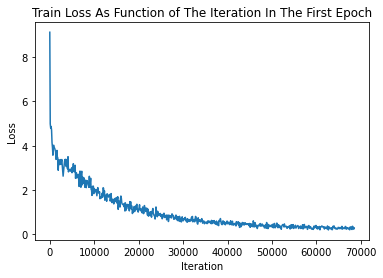

In [ ]:
plt.plot(range(1,len(loss_list), 100), loss_list[1::100])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Train Loss As Function of The Iteration In The First Epoch")

### Part (c) -- 7%

This model requires many epochs (>50) to train, and is quite slow without using a GPU.
You can train a model yourself, or you can load the model weights that we have trained,
and available on the course website (AE_RNN_model.pk).

Assuming that your `AutoEncoder` is set up correctly, the following code should run without
error.

In [ ]:
model = AutoEncoder(10000, 128, 128)
checkpoint_path = '/content/gdrive/Shareddrives/DNN_Elad_Raviv/ASS/ass4/AE_RNN_model.pk' # Update me
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Then, repeat your code from Q2(d), for `train_data[10].title`
with temperature settings 0.7, 0.9, and 1.5.
Explain why we generally don't want the temperature setting to
be too **small**.

In [ ]:
# Include the generated sequences and explanation in your PDF report.

headline = train_data[10].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()

# Include the generated sequences and explanation in your PDF report.
hidden = model.encode(input_seq)

for temp in [0.7 ,0.9, 1.5]:
  print("########## Temprature {0} ###########\n".format(temp))
  for i in range(5):
    print("Sentence {0}: {1}".format(i, sample_sequence(model, hidden, temperature=temp)))

# ...

########## Temprature 0.7 ###########

Sentence 0: ['wall', 'street', 'rises', ',', 'limps', 'heist', ',', 'chances', 'blast', 'support', 'after', 'commission', '-minister']
Sentence 1: ['wall', 'street', 'rises', ',', 'limps', 'die', 'win', 'at', 'of', 'sciences', '<pad>', 'presidential', 'amid']
Sentence 2: ['wall', 'street', 'rises', ',', 'limps', 'die', 'win', "'s", 'employees', '<pad>', 'one-time', 'after', 'wto']
Sentence 3: ['wall', 'street', 'rises', ',', 'limps', 'die', 'win', 'at', 'of', 'sciences', ':', 'libya', 'power']
Sentence 4: ['wall', 'street', 'rises', ',', 'limps', 'open', 'sentence', 'second', ',', 'message', 'next', 'abu', 'bites']
########## Temprature 0.9 ###########

Sentence 0: ['wall', 'street', 'rises', ',', 'limps', 'die', 'win', "'s", 'point', 'only', 'for', 'friday', 'month']
Sentence 1: ['wall', 'street', 'rises', ',', 'limps', 'and', 'turn', 'coaching', 'on', '<pad>', 'against', 'kenya', 'showdown']
Sentence 2: ['wall', 'street', 'rises', ',', 'limps', 

**Write your explanation here:**
As satated before, by changing the temperature we can control the output-vector's variance and as an extension the probability of words to be drawn out of the transformed distribution. 
If we want the decoder to perform as a *generator* of headlines, we should not use too low of a temperature as it withers the model, and forces it to generate very similar headlines.
we need to be setting the tempature high enough so that the model will be able to generate a variety of words, and not generates words that are very similar to the ones which were inserted initialy .

## Question 4. Latent space manipulations (20%)

In parts 2-3, we've explored the decoder portion of the autoencoder. In this section,
let's explore the **encoder**. In particular, the encoder RNN gives us 
embeddings of news headlines!

First, let's load the **validation** data set:

In [ ]:
valid_data = data.TabularDataset(
    path=valid_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

### Part (a) -- 4%

Compute the embeddings of every item in the validation set. Then, store the
result in a single PyTorch tensor of shape `[19046, 128]`, since there are
19,046 headlines in the validation set.

In [ ]:
# Write your code here
# Show that your resulting PyTorch tensor has shape `[19046, 128]`
embeddings = []
for data_point in valid_data:
  headline = data_point.title
  input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()
  embeddings.append(model.encode(input_seq))

embeddings = [embedding.squeeze() for embedding in embeddings]
embeddings = torch.stack(embeddings)
print(embeddings.size(), 'is the shape of the embedding')

torch.Size([19046, 128]) is the shape of the embedding


### Part (b) -- 4%

Find the 5 closest headlines to the headline `valid_data[13]`. Use the
cosine similarity to determine closeness. (Hint: You can use code from assignment 2)

In [ ]:
headline_sim = similarities[13, :]
headline_sim[13] = -np.inf
closest_headlines_idxes = headline_sim.argsort()[-5:][::-1]

print("The 5 closest headlines to '{}':".format(' '.join(valid_data[13].title)))
for i, cls_headline_idx in enumerate(closest_headlines_idxes):
  print(str(i+1)+". ", "Similarity {:.3f}  :".format(headline_sim[cls_headline_idx]), "'"+' '.join(valid_data[cls_headline_idx].title)+"'") 


The 5 closest headlines to '<bos> asia takes heart from new year gains in u.s. stock futures <eos>':
1.  Similarity 0.931  : '<bos> italy 's salvini loses aura of invincibility in emilia setback <eos>'
2.  Similarity 0.931  : '<bos> saudi , russia look to seal deeper output cuts with oil producers <eos>'
3.  Similarity 0.930  : '<bos> eu orders quarantine for staff who traveled to northern italy <eos>'
4.  Similarity 0.929  : '<bos> update _num_-italy 's prime minister says new government will bicker less <eos>'
5.  Similarity 0.928  : '<bos> portugal 's moura pays tribute to cod fishermen at milan fashion close <eos>'


### Part (c) -- 4%

Find the 5 closest headlines to another headline of your choice.

In [ ]:
headline_sim = similarities[12, :]
headline_sim[12] = -np.inf
closest_headlines_idxes = headline_sim.argsort()[-5:][::-1]

print("The 5 closest headlines to '{}':".format(' '.join(valid_data[12].title)))
for i, cls_headline_idx in enumerate(closest_headlines_idxes):
  print(str(i+1)+". ", "Similarity {:.3f}  :".format(headline_sim[cls_headline_idx]), "'"+' '.join(valid_data[cls_headline_idx].title)+"'") 


The 5 closest headlines to '<bos> south korea 's hyundai target _num_ global sales of _num_ million vehicles <eos>':
1.  Similarity 0.952  : '<bos> south africa 's manufacturing up _num_ % y/y in april , highest in _num_ years <eos>'
2.  Similarity 0.951  : '<bos> south africa 's gross domestic spending up _num_ % in second quarter <eos>'
3.  Similarity 0.948  : '<bos> south africa 's retail sales up _num_ % year/year in october <eos>'
4.  Similarity 0.945  : '<bos> online and discounters to drive _num_ % growth in uk grocery by _num_ <eos>'
5.  Similarity 0.945  : '<bos> update _num_-egypt signs energy accords at conference in new capital <eos>'


### Part (d) -- 8%

Choose two headlines from the validation set, and find their embeddings.
We will **interpolate** between the two embeddings like we did in the example presented in class for training autoencoders on MNIST.

Find 3 points, equally spaced between the embeddings of your headlines.
If we let $e_0$ be the embedding of your first headline and $e_4$ be
the embedding of your second headline, your three points should be:

\begin{align*}
e_1 &=  0.75 e_0 + 0.25 e_4 \\
e_2 &=  0.50 e_0 + 0.50 e_4 \\
e_3 &=  0.25 e_0 + 0.75 e_4 \\
\end{align*}

Decode each of $e_1$, $e_2$ and $e_3$ five times, with a temperature setting
that shows some variation in the generated sequences. Try to get a logical and cool sentence (this might be hard).

In [ ]:
# Write your code here. Include your generated sequences.
head0 = valid_data[200].title
input_seq = torch.Tensor([vocab.stoi[w] for w in head0]).unsqueeze(0).long()
e0 = model.encode(input_seq)
print("e0:", ' '.join(head0))

head4 = valid_data[300].title
input_seq = torch.Tensor([vocab.stoi[w] for w in head4]).unsqueeze(0).long()
e4 = model.encode(input_seq)
print("e4:", ' '.join(head4))

e1 = 0.75*e0 + 0.25*e4
e2 = 0.50*e0 + 0.50*e4
e3 = 0.25*e0 + 0.75*e4

temp = 1.6
print("Temperature:",temp)
ex = ["e1", "e2", "e3"]

for e_index, e in enumerate([e1, e2, e3]):
  print(ex[e_index],"decodings:")
  for i in range(5):
    print(sample_sequence(model, e, temperature=temp))

e0: <bos> new york weatherman fired over racial slur in forecast <eos>
e4: <bos> honda to shut uk production for six days due to brexit logistics <eos>
Temperature: 1.6
e1 decodings:
['<unk>', 'u.s.', 'philadelphia', 'set', 'former', 'infected', 'explore', 'profit', ':']
['abused', 'canada', 'nigeria', 'washington', 'vehicles', ',', 'four', 'supreme', 'annual']
['new', 'genetic', 'india', 'channels', 'pleads', 'with', 'employees', '<pad>', 'results', '-sources']
['dubai', 'charged', '<unk>', 'foreign', 'general', 'lack', 'since', 'ups', 'cuts']
['corbyn', 'tiffany', 'business', 'an', 'military', 'file', 'chemical', '<unk>', 'christmas']
e2 decodings:
['wework', 'may', "'", 'guilt', 'u.s.', 'funds', 'wound', "'s", 'reuters', 'helm']
['wpp', 'bank', 'pm', 'patients', 'one', 'by', 'outraged', 'after', 'department', 'survey']
['score', 'airlines', 'among', 'japan', 'knights', 'coronavirus', 'northern', 'trial', 'title', 'december']
['indicted', 'air', 'prepares', 'sale', 'forces', 'marks',